In [1]:
# !pip install plotly
# !pip install matplotlib==3.5.0

In [2]:
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm, trange

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import plotly.express as px
from difflib import SequenceMatcher
import seaborn as sns

In [3]:
def millions(x, pos):
    """The two args are the value and tick position."""
    return '{:1.1f}M'.format(x*1e-6)


In [433]:
all_data = pd.read_pickle('data/morbilidad_global_lima.pkl')
# #all_data = all_data[(all_data['YEAR']>=2018) & (all_data['YEAR']<2022)]
# all_data = all_data[(all_data['YEAR']>=2018)]
# all_data['IS_LIMA'] = all_data['PROVINCE'].apply(lambda x : True if x=='LIMA' else False)
# all_data['SECTOR'] = all_data['SECTOR'].apply(lambda x: 'PRIVATE' if x == 'PRIVADO' else 'PUBLIC')
all_data['SECTOR'] = all_data['SECTOR2']
all_data.head()

,DATE,YEAR,MONTH,STATE,PROVINCE,DISTRICT,SECTOR,CATEGORY,CATEGORY2,CO_IPRESS,...,DIAGNOSIS_ID,QTY_PEOPLE_SERVED,DISEASE,DISEASE_GROUP,COD_IPRESS,x,y,SECTOR_R,TYPE,SECTOR2
0,2021-12-01,2021,12,LIMA,LIMA,LOS OLIVOS,PRIVATE,II-E,II,00023151,...,N39.0,5,"URINARY TRACT INFECTION, SITE NOT SPECIFIED",Diseases of the genitourinary system,00023151,-11.99116,-77.073203,PRIVADO,Outpatient Consultation,PRIVATE
1,2021-12-01,2021,12,LIMA,LIMA,LOS OLIVOS,PRIVATE,II-E,II,00023151,...,N39.0,4,"URINARY TRACT INFECTION, SITE NOT SPECIFIED",Diseases of the genitourinary system,00023151,-11.99116,-77.073203,PRIVADO,Outpatient Consultation,PRIVATE
2,2021-12-01,2021,12,LIMA,LIMA,LOS OLIVOS,PRIVATE,II-E,II,00023151,...,N77.1,8,"VAGINITIS, VULVITIS AND VULVOVAGINITIS IN DIS ...",Diseases of the genitourinary system,00023151,-11.99116,-77.073203,PRIVADO,Outpatient Consultation,PRIVATE
3,2021-12-01,2021,12,LIMA,LIMA,LOS OLIVOS,PRIVATE,II-E,II,00023151,...,N39.0,4,"URINARY TRACT INFECTION, SITE NOT SPECIFIED",Diseases of the genitourinary system,00023151,-11.99116,-77.073203,PRIVADO,Outpatient Consultation,PRIVATE
4,2021-12-01,2021,12,LIMA,LIMA,LOS OLIVOS,PRIVATE,II-E,II,00023151,...,N39.0,5,"URINARY TRACT INFECTION, SITE NOT SPECIFIED",Diseases of the genitourinary system,00023151,-11.99116,-77.073203,PRIVADO,Outpatient Consultation,PRIVATE


In [434]:
set(all_data['CATEGORY'])

{'0', 'I-2', 'I-3', 'I-4', 'II-1', 'II-2', 'II-E', 'III-1', 'III-2', 'III-E'}

In [5]:
diagnostics_tag = np.unique(all_data['DISEASE_GROUP'])

cmap = cm.get_cmap('tab20b', 256)
colorsb = cmap(np.linspace(0, 1, 20))
cmap = cm.get_cmap('tab20c', 256)
colorsc = cmap(np.linspace(0, 1, 20))[8:-4]

colors = list(colorsc)+list(colorsb)
# new_colors = []
# for i in range(len(colorsc)):
#     new_colors.append(colorsc[i])
#     new_colors.append(colorsb[i])

dict_colors = {}
counter = 0
for d in diagnostics_tag:
    x=colors[counter]
    dict_colors[d]=matplotlib.colors.rgb2hex(x)
    counter+=1

#### Lima data 

In [6]:
PARAMETER = 'DISEASE_GROUP'

data_temp = all_data.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.reset_index(drop=True)
    temp_df = temp_df.head(5).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

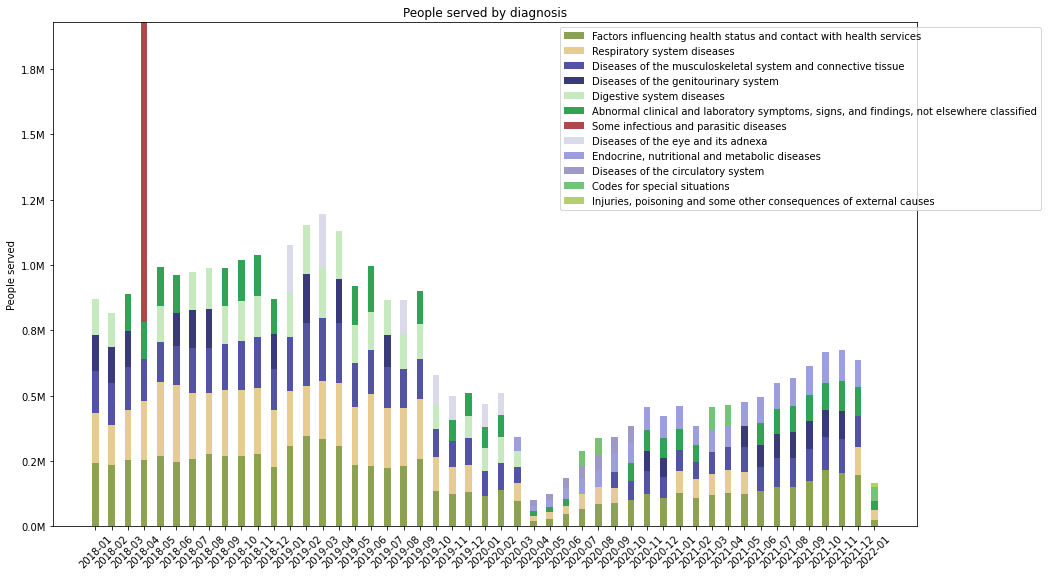

In [7]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=dict_colors[diag])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1))
plt.show()

In [8]:
data_temp = all_data.groupby(['DATE','DISEASE']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE']).agg({ 'QTY_PEOPLE_SERVED': ['sum', 'count']})
data_temp.columns = data_temp.columns.droplevel()
data_temp = data_temp.reset_index()

data_temp = data_temp.rename(columns={'sum': 'People_served', 'count': 'Unique_diagnosis'})

### Top 10 diagnosis 

In [9]:
PARAMETER = 'DISEASE_GROUP'

data_temp = all_data.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    #temp_df = temp_df.head(10).reset_index(drop=True)
    temp_df = temp_df.reset_index(drop=True)
    total = sum(temp_df['QTY_PEOPLE_SERVED'])
    temp_df['PER'] = temp_df['QTY_PEOPLE_SERVED']/total*100
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    temp_df['PER']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

Sanity check for IHM using respiratory deseases. In IHM profile respiratory desease is 8% for Peru while in our Lima dataset we have arronf 9%


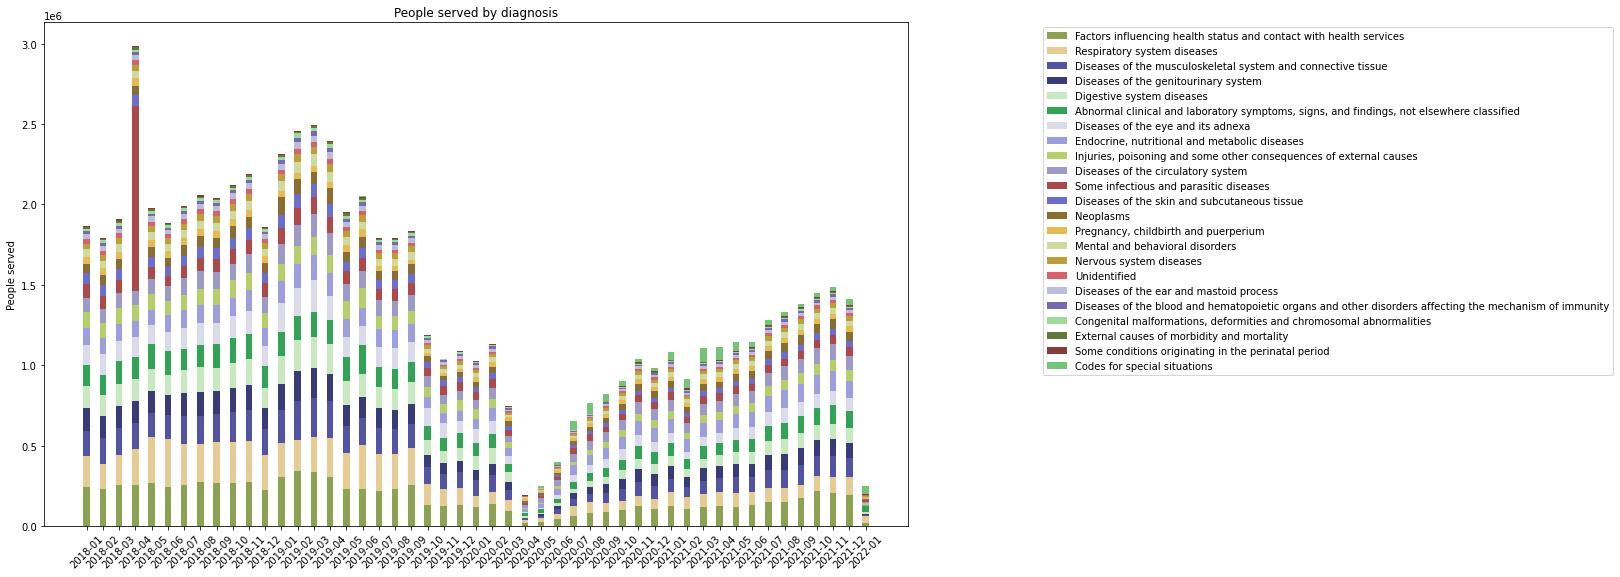

In [10]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40


fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=dict_colors[diag])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45) 

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1))
plt.show()

## Estudio por categorias y diagnosticos

In [11]:
import plotly.express as px

In [12]:
def top_of_df(data, top = 5):
    df = data.copy()
    for row in range(len(df)):
        list_values = df.loc[row, columns_name].values
        top_values = list(-np.sort(-list_values)[:top])

        for i in range(list_values.size):
            val = list_values[i]
            if val in top_values:
                df.iloc[[row],i+1] = val
            else:
                df.iloc[[row],i+1] = 0
    df = df.loc[:, (df != 0).any(axis=0)]
    df = df.replace(0,np.nan)
    return df

# CODE

In [353]:
print(set(all_data['DISEASE_GROUP']))

print()
data_temp = all_data[all_data['DISEASE_GROUP']=='Codes for special situations']
print(set(data_temp['DIAGNOSIS_ID']))

data_temp['DISEASE_NAME'] = data_temp['DIAGNOSIS_ID'].apply(lambda x : diagnosis_grouped(x, CO_IPRESS_df))
diagnostics_specials = np.unique(data_temp['DISEASE_NAME'])

cmap = cm.get_cmap('tab20c', 256)
colorsb = cmap(np.linspace(0, 1, 20))
cmap = cm.get_cmap('tab20b', 256)
colorsc = cmap(np.linspace(0, 1, 20))[8:-4]

colors = list(colorsc)+list(colorsb)

dict_special_colors = {}
counter = 0
for d in diagnostics_specials:
    x=colors[counter]
    dict_special_colors[d]=matplotlib.colors.rgb2hex(x)
    counter+=1

{'Endocrine, nutritional and metabolic diseases', 'Congenital malformations, deformities and chromosomal abnormalities', 'Mental and behavioral disorders', 'Some infectious and parasitic diseases', 'Diseases of the ear and mastoid process', 'Abnormal clinical and laboratory symptoms, signs, and findings, not elsewhere classified', 'Diseases of the genitourinary system', 'Some conditions originating in the perinatal period', 'Unidentified', 'Digestive system diseases', 'Diseases of the blood and hematopoietic organs and other disorders affecting the mechanism of immunity', 'External causes of morbidity and mortality', 'Pregnancy, childbirth and puerperium', 'Respiratory system diseases', 'Nervous system diseases', 'Diseases of the circulatory system', 'Neoplasms', 'Diseases of the eye and its adnexa', 'Factors influencing health status and contact with health services', 'Codes for special situations', 'Diseases of the skin and subcutaneous tissue', 'Diseases of the musculoskeletal syste

/tmp/ipykernel_167092/3892249879.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [327]:
set(all_data['CATEGORY2'])

{'0', 'I', 'II', 'III'}

In [401]:
CATEGORIA_STUDIO = 'III'

### Private & Public 

In [402]:
all_data.head()

,DATE,YEAR,MONTH,STATE,PROVINCE,DISTRICT,SECTOR,CATEGORY,CATEGORY2,CO_IPRESS,...,DIAGNOSIS_ID,QTY_PEOPLE_SERVED,DISEASE,DISEASE_GROUP,COD_IPRESS,x,y,SECTOR_R,TYPE,SECTOR2
0,2021-12-01,2021,12,LIMA,LIMA,LOS OLIVOS,PRIVATE,II-E,II,00023151,...,N39.0,5,"URINARY TRACT INFECTION, SITE NOT SPECIFIED",Diseases of the genitourinary system,00023151,-11.99116,-77.073203,PRIVADO,Outpatient Consultation,PRIVATE
1,2021-12-01,2021,12,LIMA,LIMA,LOS OLIVOS,PRIVATE,II-E,II,00023151,...,N39.0,4,"URINARY TRACT INFECTION, SITE NOT SPECIFIED",Diseases of the genitourinary system,00023151,-11.99116,-77.073203,PRIVADO,Outpatient Consultation,PRIVATE
2,2021-12-01,2021,12,LIMA,LIMA,LOS OLIVOS,PRIVATE,II-E,II,00023151,...,N77.1,8,"VAGINITIS, VULVITIS AND VULVOVAGINITIS IN DIS ...",Diseases of the genitourinary system,00023151,-11.99116,-77.073203,PRIVADO,Outpatient Consultation,PRIVATE
3,2021-12-01,2021,12,LIMA,LIMA,LOS OLIVOS,PRIVATE,II-E,II,00023151,...,N39.0,4,"URINARY TRACT INFECTION, SITE NOT SPECIFIED",Diseases of the genitourinary system,00023151,-11.99116,-77.073203,PRIVADO,Outpatient Consultation,PRIVATE
4,2021-12-01,2021,12,LIMA,LIMA,LOS OLIVOS,PRIVATE,II-E,II,00023151,...,N39.0,5,"URINARY TRACT INFECTION, SITE NOT SPECIFIED",Diseases of the genitourinary system,00023151,-11.99116,-77.073203,PRIVADO,Outpatient Consultation,PRIVATE


In [403]:
data_temp = all_data[all_data['CATEGORY2']==CATEGORIA_STUDIO]
data_temp =  data_temp.groupby(['DATE', 'SECTOR']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

#data_temp['QTY_PEOPLE_SERVED'] =data_temp['QTY_PEOPLE_SERVED'].mask((data_temp['DATE'].dt.year==2018) & (data_temp['DATE'].dt.month==4),0)

data_temp = data_temp.pivot_table(index=['DATE'], 
                                  columns=['SECTOR'], 
                                  values='QTY_PEOPLE_SERVED').fillna(0)
data_temp = data_temp.reset_index()

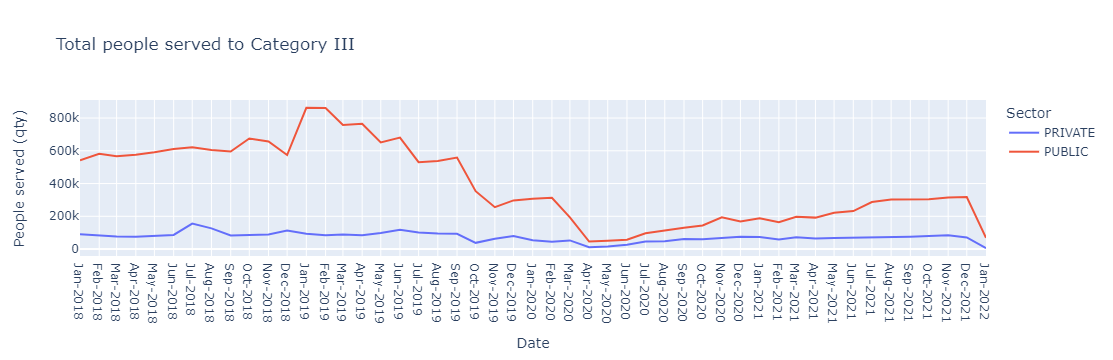

In [404]:
df = data_temp
columns_name = list(df.columns)[1:]
fig = px.line(df, 
              x="DATE", 
              y=columns_name,
              hover_data={"DATE": "|%Y %M"},
              labels={
                     "value": "People served (qty)",
                     "DATE": "Date",
                     "variable": "Sector"
                 },
              title='Total people served to Category ' + CATEGORIA_STUDIO)

# fig = px.scatter(data_temp, x="DATE", y=data_temp.columns,
#               hover_data={"DATE": "|%Y %M"},
#               labels={
#                      "value": "People served (qty)",
#                      "DATE": "Date",
#                      "SECTOR2": "Sector"
#                  },
#               title='Total people served to Category ' + CATEGORIA_STUDIO)

fig.update_xaxes(
    dtick="M1",
    tickformat="%b-%Y")
fig.show()

In [405]:
data_temp = all_data[all_data['CATEGORY2']==CATEGORIA_STUDIO]

data_temp =  data_temp.groupby(['DATE', 'SECTOR', 'DISEASE_GROUP']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

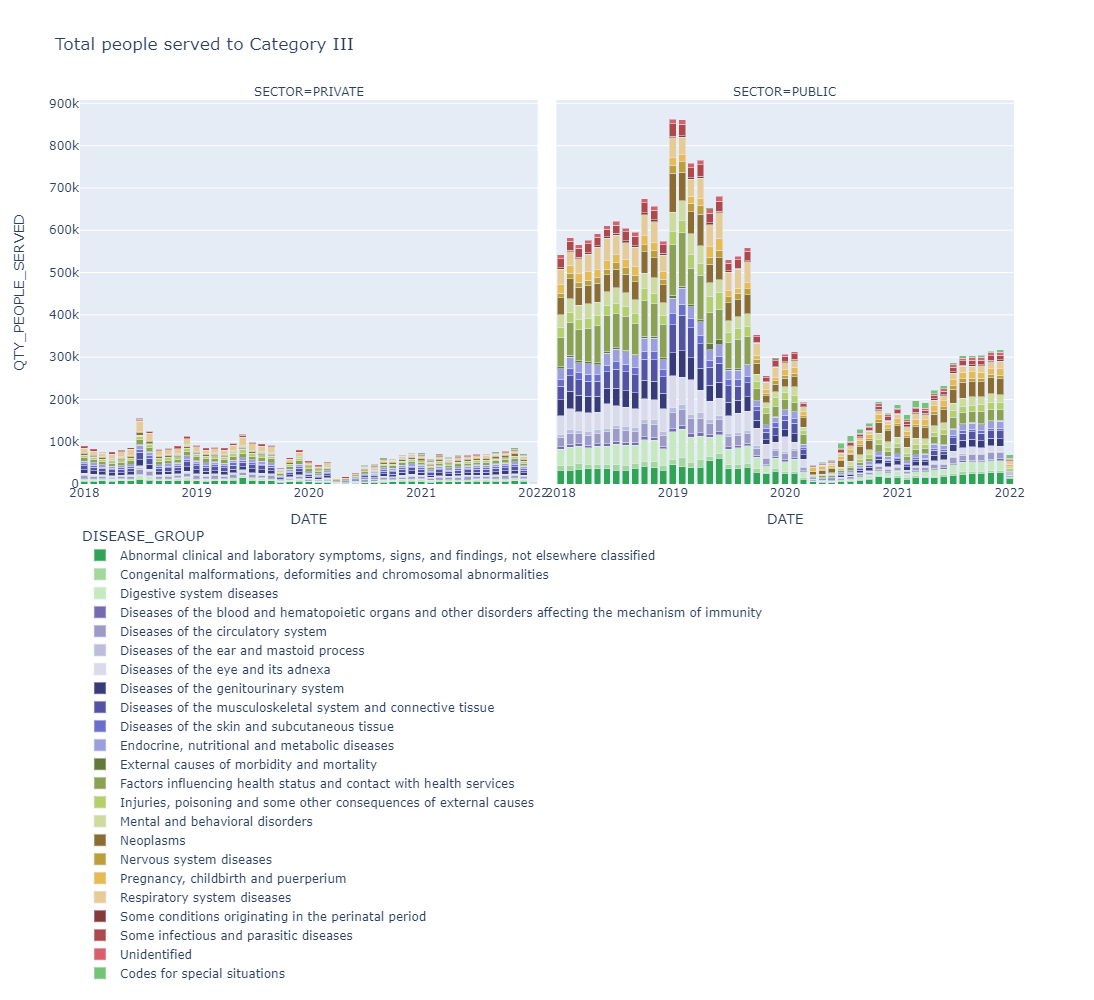

In [406]:
fig = px.bar(data_temp, 
             x="DATE", 
             y="QTY_PEOPLE_SERVED", 
             color="DISEASE_GROUP", 
             barmode="stack", 
             facet_col="SECTOR",
             width=1000, height=1000,
             color_discrete_map = dict_colors,
             title='Total people served to Category ' + CATEGORIA_STUDIO,
            )
        
fig.update_layout(legend=dict(yanchor="top",
                              y=-0.1,
                              xanchor="left",
                              x=0
                             ),
                  showlegend=True
                 )

fig.show()
fig.write_html("figures/Sector_"+CATEGORIA_STUDIO+".html")

### Normalized by Hospital and People (qty)

In [417]:
data_temp = all_data[all_data['CATEGORY2']==CATEGORIA_STUDIO]


data_hosp =  data_temp.groupby(['DATE', 'SECTOR', 'CO_IPRESS']).agg({ 'QTY_PEOPLE_SERVED': "count"})
data_hosp = data_hosp.reset_index()
data_hosp =  data_hosp.groupby(['DATE', 'SECTOR']).agg({ 'CO_IPRESS': "count"})
data_hosp = data_hosp.reset_index()

data_temp =  data_temp.groupby(['DATE', 'SECTOR', 'DISEASE_GROUP']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

data_pers =  data_temp.groupby(['DATE', 'SECTOR']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_pers = data_pers.reset_index()

#data_temp['QTY_PEOPLE_SERVED'] =data_temp['QTY_PEOPLE_SERVED'].mask((data_temp['DATE'].dt.year==2018) & (data_temp['DATE'].dt.month==4),0)

data_temp = pd.merge(data_temp, data_hosp, how='inner', on=('DATE','SECTOR'))
data_temp['NORMALIZED_HOSPITAL'] = data_temp['QTY_PEOPLE_SERVED']/data_temp['CO_IPRESS']


data_temp = pd.merge(data_temp, data_pers, how='inner', on=('DATE','SECTOR'))
data_temp['NORMALIZED_PEOPLE'] = data_temp['QTY_PEOPLE_SERVED_x']/data_temp['QTY_PEOPLE_SERVED_y']


#### Graph to Normalized by hospital

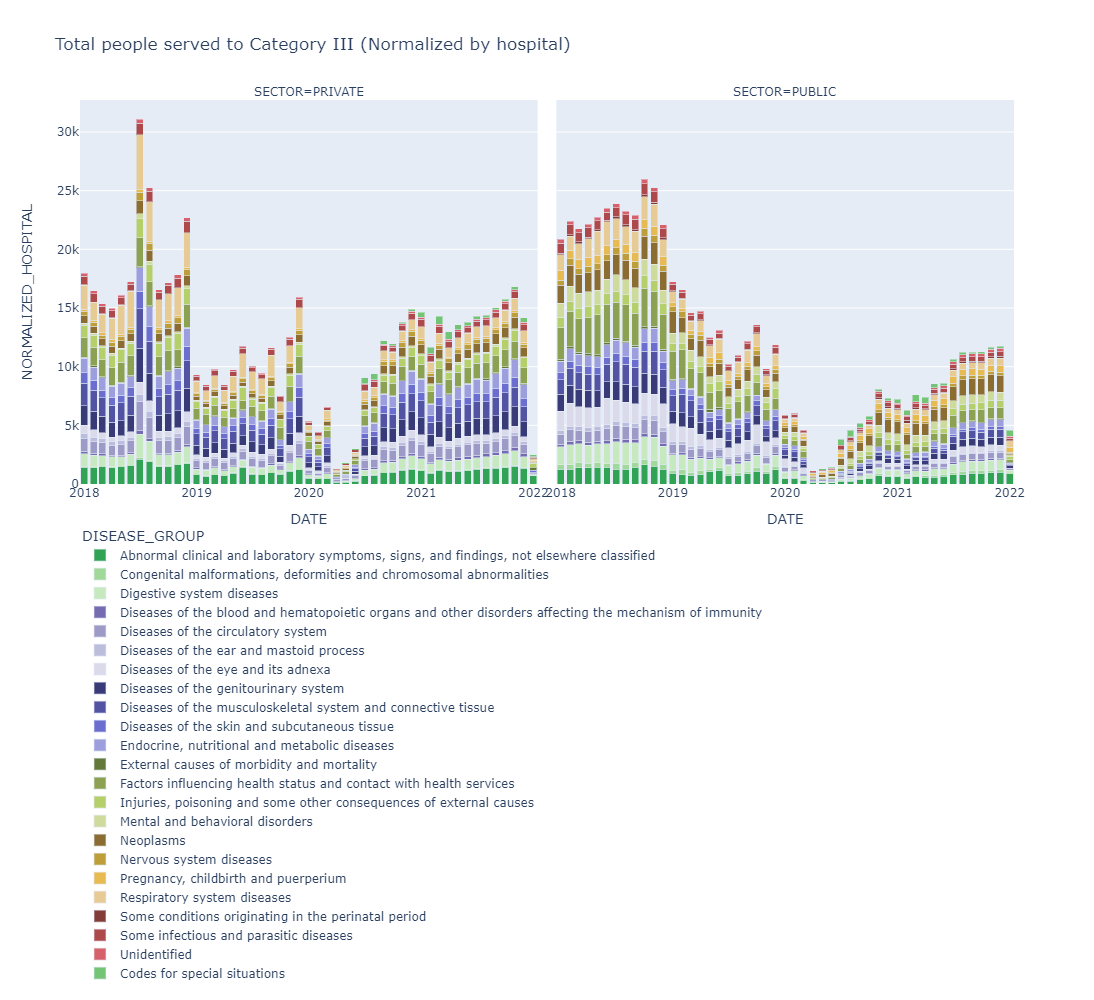

In [418]:
fig = px.bar(data_temp, 
             x="DATE", 
             y="NORMALIZED_HOSPITAL", 
             color="DISEASE_GROUP", 
             barmode="stack", 
             facet_col="SECTOR",
             width=1000, height=1000,
             color_discrete_map = dict_colors,
             title='Total people served to Category ' + CATEGORIA_STUDIO + ' (Normalized by hospital)',
            )

fig.update_layout(legend=dict(yanchor="top",
                              y=-0.1,
                              xanchor="left",
                              x=0
                             ),
                  showlegend=True
                 )

fig.show()
fig.write_html("figures/Sector_Normalized_Hospitals_Cat-"+CATEGORIA_STUDIO+"_bar.html")

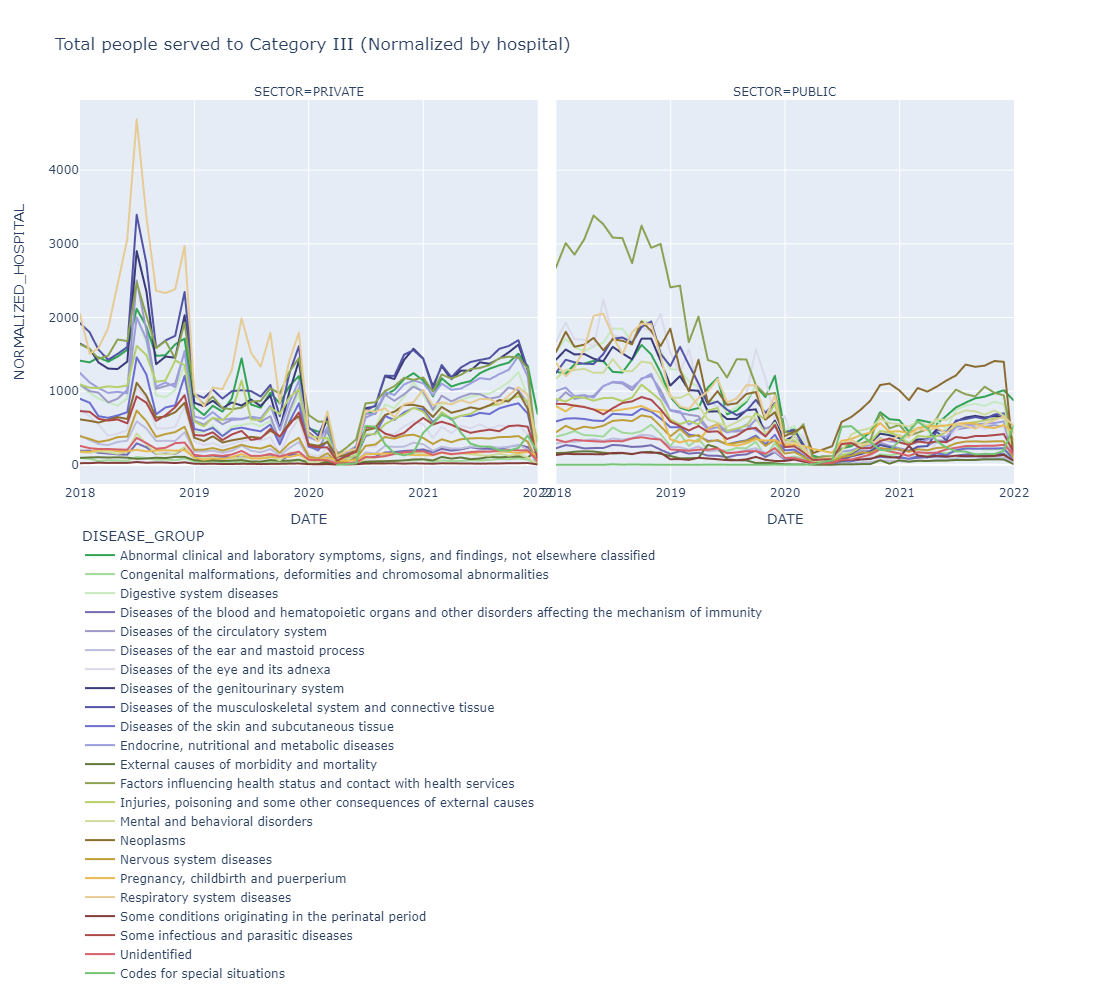

In [419]:
fig = px.line(data_temp, 
                 x="DATE", 
                 y="NORMALIZED_HOSPITAL", 
                 color="DISEASE_GROUP", 
                 facet_col="SECTOR",
                 width=1000, height=1000,
                 color_discrete_map = dict_colors,
                 title='Total people served to Category ' + CATEGORIA_STUDIO + ' (Normalized by hospital)',
             )

fig.update_layout(legend=dict(yanchor="top",
                              y=-0.1,
                              xanchor="left",
                              x=0
                             ),
                  showlegend=True
                 )

fig.show()
fig.write_html("figures/Sector_Normalized_Hospitals_Cat-"+CATEGORIA_STUDIO+"_line.html")

#### Graph to Normalized by people

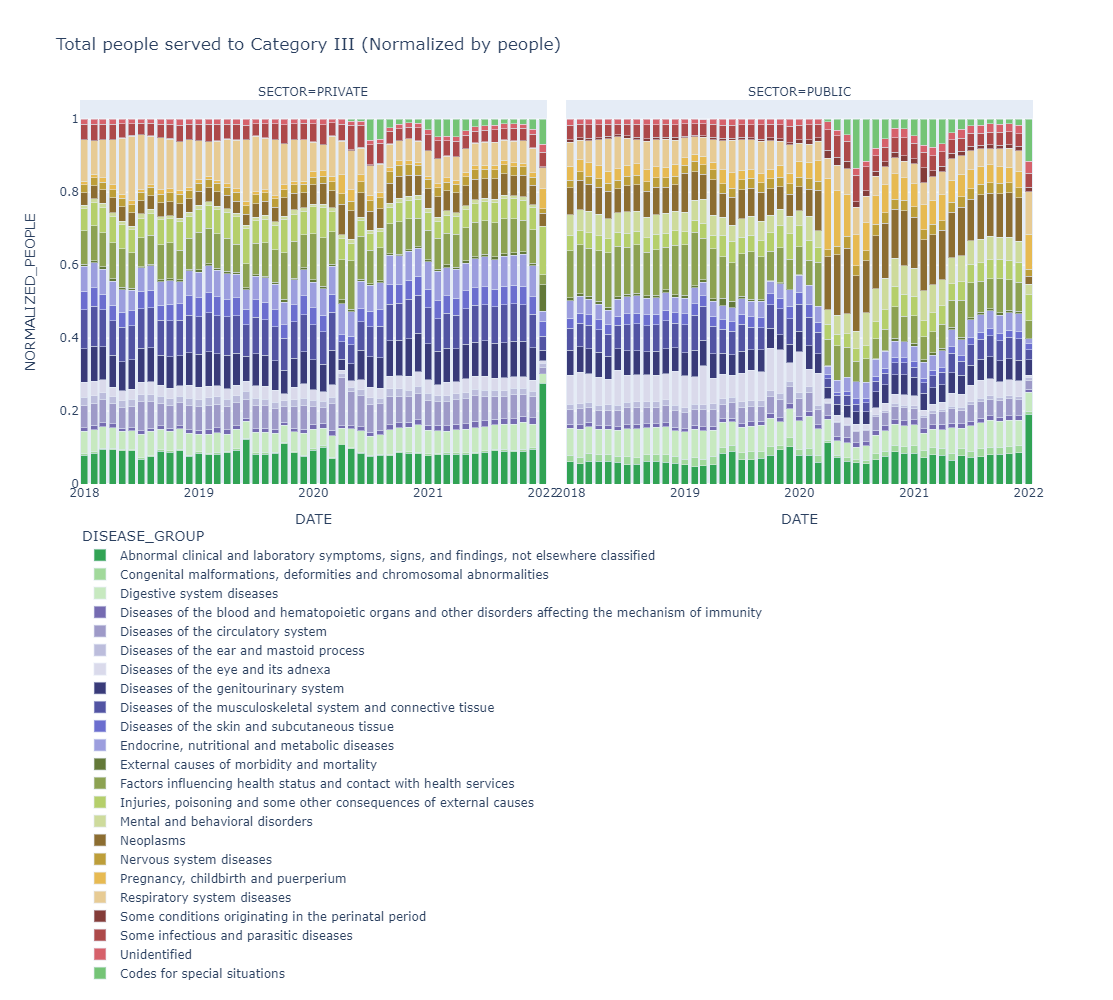

In [420]:
fig = px.bar(data_temp, 
             x="DATE", 
             y="NORMALIZED_PEOPLE", 
             color="DISEASE_GROUP", 
             barmode="stack", 
             facet_col="SECTOR",
             width=1000, height=1000,
             color_discrete_map = dict_colors,
             title='Total people served to Category ' + CATEGORIA_STUDIO + ' (Normalized by people)',
            )


fig.update_layout(legend=dict(yanchor="top",
                              y=-0.1,
                              xanchor="left",
                              x=0
                             ),
                  showlegend=True
                 )

fig.show()
fig.write_html("figures/Sector_Normalized_People_Cat-"+CATEGORIA_STUDIO+"_bar.html")

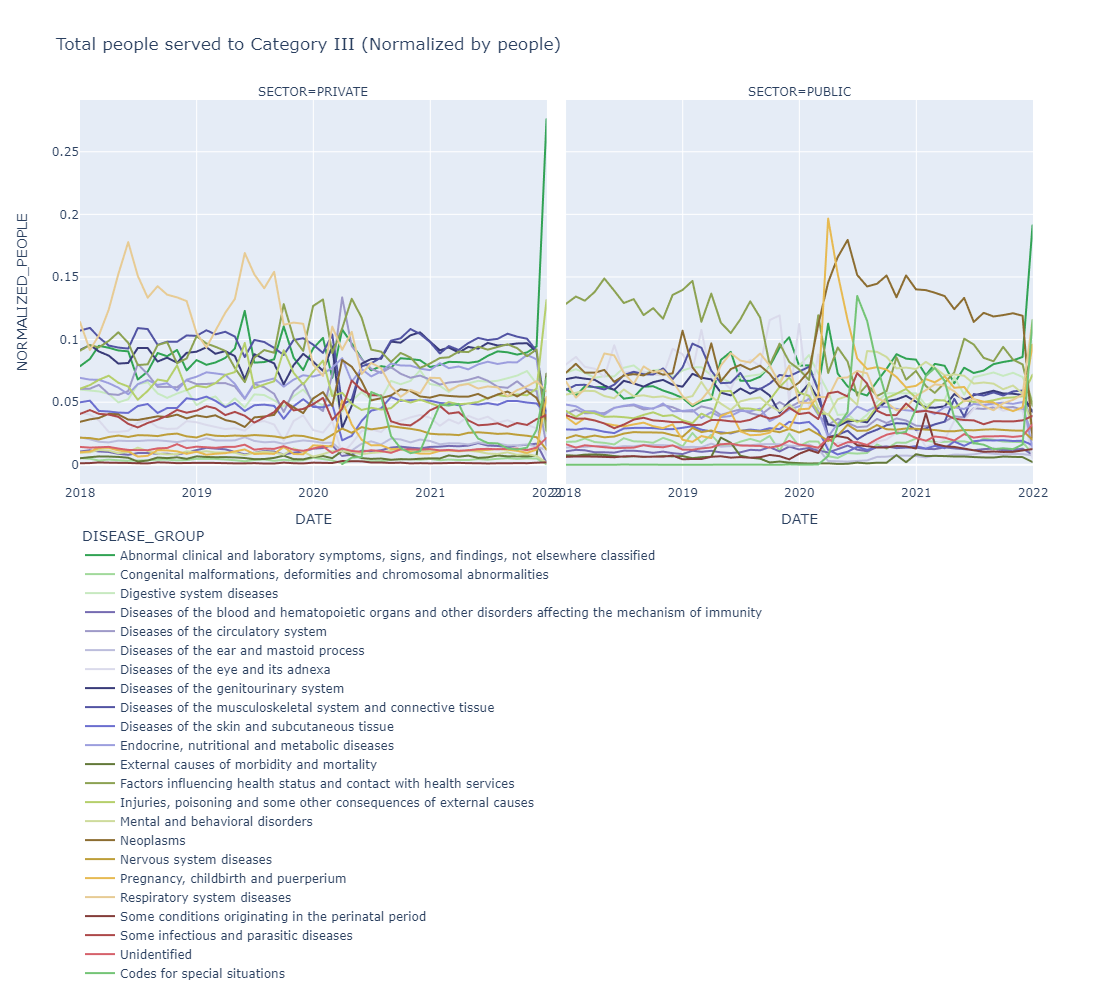

In [421]:
fig = px.line(data_temp, 
                 x="DATE", 
                 y="NORMALIZED_PEOPLE", 
                 color="DISEASE_GROUP", 
                 facet_col="SECTOR",
                 width=1000, height=1000,
                 color_discrete_map = dict_colors,
                 title='Total people served to Category ' + CATEGORIA_STUDIO + ' (Normalized by people)'
             )


fig.update_layout(legend=dict(yanchor="top",
                              y=-0.1,
                              xanchor="left",
                              x=0
                             ),
                  showlegend=True
                 )

fig.show()
fig.write_html("figures/Sector_Normalized_People_Cat-"+CATEGORIA_STUDIO+"_line.html")

#### Number of hopital

In [422]:
data_temp = all_data[all_data['CATEGORY2']==CATEGORIA_STUDIO]

data_temp =  data_temp.groupby(['DATE', 'SECTOR', 'CO_IPRESS']).agg({ 'QTY_PEOPLE_SERVED': ['sum','count']})
data_temp.columns = data_temp.columns.droplevel()
data_temp = data_temp.reset_index()

data_temp =  data_temp.groupby(['DATE', 'SECTOR']).agg({ 'CO_IPRESS': ['count']})
data_temp.columns = data_temp.columns.droplevel()
data_temp = data_temp.reset_index()

data_temp = data_temp.rename(columns={'count':'Hospitals Qty',})

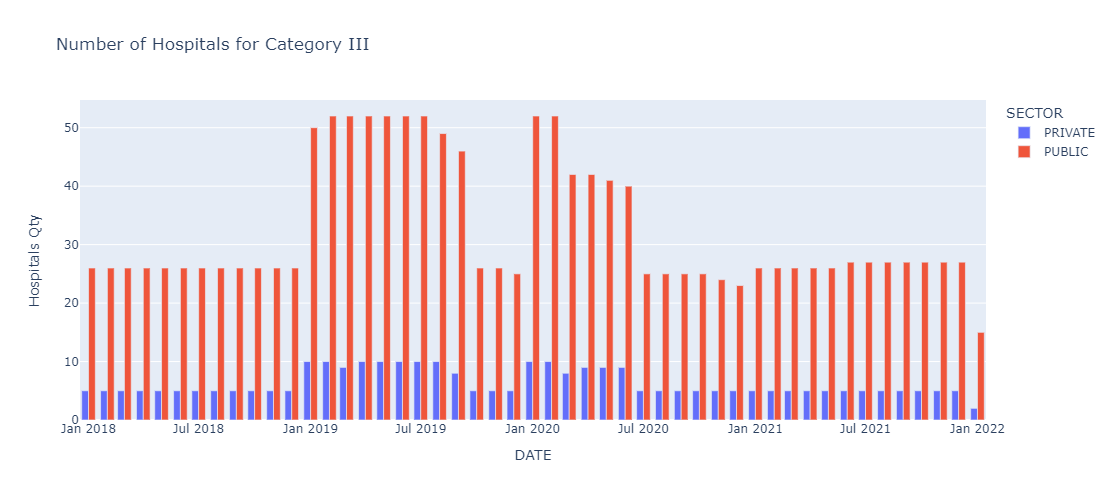

In [424]:
fig = px.bar(data_temp, 
             x="DATE", 
             y="Hospitals Qty", 
             color="SECTOR", 
             barmode="group", 
             width=1000, height=500,
             title='Number of Hospitals for Category ' + CATEGORIA_STUDIO,
            )     
fig.show()
#fig.write_html("figures/hospital_qty/category_"+CATEGORIA_STUDIO+"_bars.html")
fig.write_image("figures/hospital_qty/category_"+CATEGORIA_STUDIO+"_bars.png", format  = 'png')

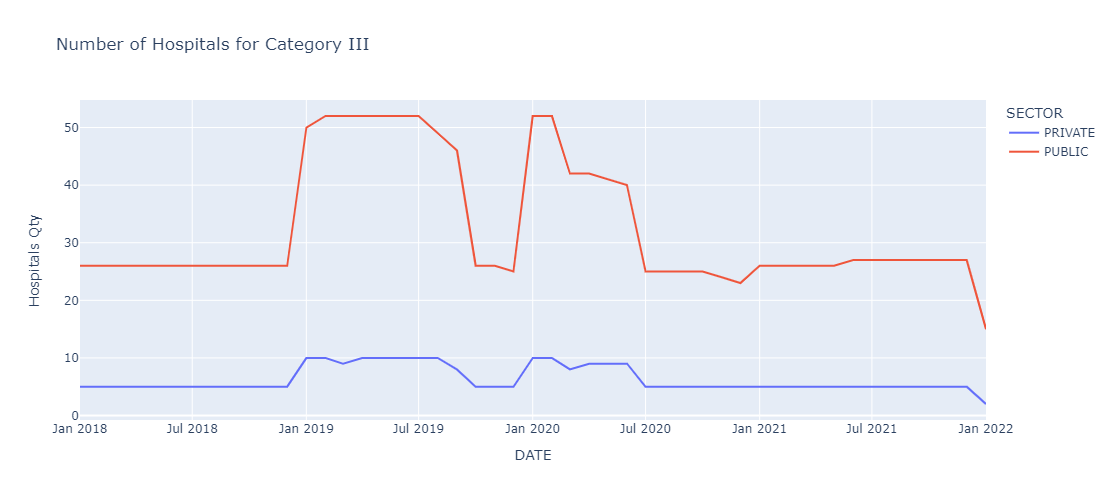

In [425]:
fig = px.line(data_temp, 
             x="DATE", 
             y="Hospitals Qty", 
             color="SECTOR",
             width=1000, height=500,
             title='Number of Hospitals for Category ' + CATEGORIA_STUDIO,
            )     
fig.show()
#fig.write_html("figures/hospital_qty/category_"+CATEGORIA_STUDIO+"_lines.html")
fig.write_image("figures/hospital_qty/category_"+CATEGORIA_STUDIO+"_lines.png", format  = 'png')

#### Focus on Special codes

In [426]:
def diagnosis_grouped(val, values_dict):
    val = str(val)
    #val = str(val)[:2]
    try:
        val = values_dict[val][0]
    except:
        val = val
    return val

# CO_IPRESS_df[CO_IPRESS_df['CIE10_X'].str.contains("U")]

CO_IPRESS_df = pd.read_excel('web_resources/ICD10/CIE10-VOLUMEN-2018-EXCEL.xlsx', index_col=None, header=0) 
CO_IPRESS_df['DIAGNOSIS_ID'] = CO_IPRESS_df['CIE10_X'].apply(lambda x: x[:-1]+'.'+x[-1:])
CO_IPRESS_df = CO_IPRESS_df[['DIAGNOSIS_ID','DESCRIPCION CIE']]
CO_IPRESS_df = CO_IPRESS_df.rename(columns={'DESCRIPCION CIE': 'DISEASE'})
CO_IPRESS_df = CO_IPRESS_df.set_index('DIAGNOSIS_ID').T.to_dict('list')

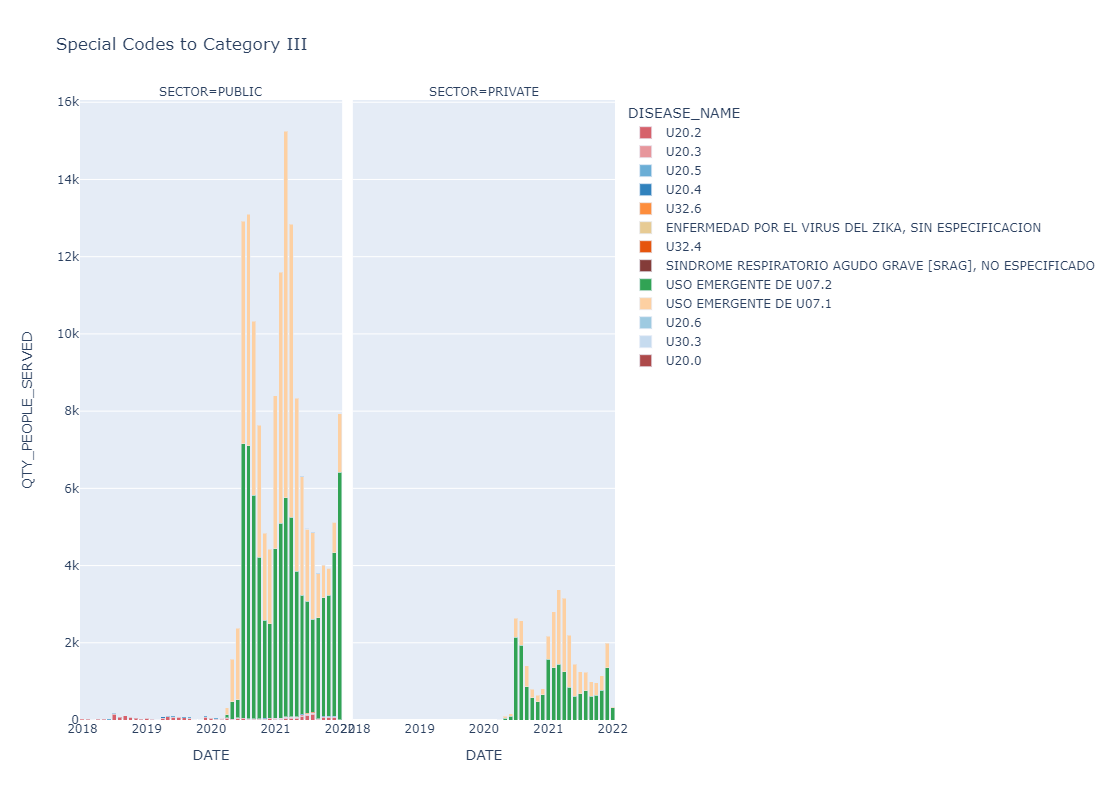

In [427]:
data_temp = all_data[all_data['CATEGORY2']==CATEGORIA_STUDIO]
data_temp = data_temp[data_temp['DISEASE_GROUP']=='Codes for special situations']
data_temp['DISEASE_NAME'] = data_temp['DIAGNOSIS_ID'].apply(lambda x : diagnosis_grouped(x, CO_IPRESS_df))

data_temp =  data_temp.groupby(['DATE', 'SECTOR','DISEASE_NAME']).agg({ 'QTY_PEOPLE_SERVED': ['sum']})
data_temp.columns = data_temp.columns.droplevel()
data_temp = data_temp.reset_index()
data_temp = data_temp.rename(columns={'sum':'QTY_PEOPLE_SERVED',})

fig = px.bar(data_temp, 
             x="DATE", 
             y="QTY_PEOPLE_SERVED", 
             color="DISEASE_NAME", 
             barmode="stack", 
             facet_col="SECTOR",
             width=1700, height=800,
             color_discrete_map = dict_special_colors,
             title='Special Codes to Category ' + CATEGORIA_STUDIO,             
            )


fig.show()
#fig.write_html("figures/special_codes/SpecialCodes_Sector_"+CATEGORIA_STUDIO+".html")
fig.write_image("figures/special_codes/SpecialCodes_Sector_"+CATEGORIA_STUDIO+".png", format  = 'png')

In [428]:
data_temp = all_data[all_data['CATEGORY2']==CATEGORIA_STUDIO]
data_temp = data_temp[data_temp['DISEASE_GROUP']=='Codes for special situations']

data_hosp =  data_temp.groupby(['DATE', 'SECTOR', 'CO_IPRESS']).agg({ 'QTY_PEOPLE_SERVED': "count"})
data_hosp = data_hosp.reset_index()
data_hosp =  data_hosp.groupby(['DATE', 'SECTOR']).agg({ 'CO_IPRESS': "count"})
data_hosp = data_hosp.reset_index()

data_temp['DISEASE_NAME'] = data_temp['DIAGNOSIS_ID'].apply(lambda x : diagnosis_grouped(x, CO_IPRESS_df))

data_temp =  data_temp.groupby(['DATE', 'SECTOR', 'DISEASE_NAME']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

data_pers =  data_temp.groupby(['DATE', 'SECTOR']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_pers = data_pers.reset_index()

#data_temp['QTY_PEOPLE_SERVED'] =data_temp['QTY_PEOPLE_SERVED'].mask((data_temp['DATE'].dt.year==2018) & (data_temp['DATE'].dt.month==4),0)

data_temp = pd.merge(data_temp, data_hosp, how='inner', on=('DATE','SECTOR'))
data_temp['NORMALIZED_HOSPITAL'] = data_temp['QTY_PEOPLE_SERVED']/data_temp['CO_IPRESS']


data_temp = pd.merge(data_temp, data_pers, how='inner', on=('DATE','SECTOR'))
data_temp['NORMALIZED_PEOPLE'] = data_temp['QTY_PEOPLE_SERVED_x']/data_temp['QTY_PEOPLE_SERVED_y']

#### Normalized by people special codes

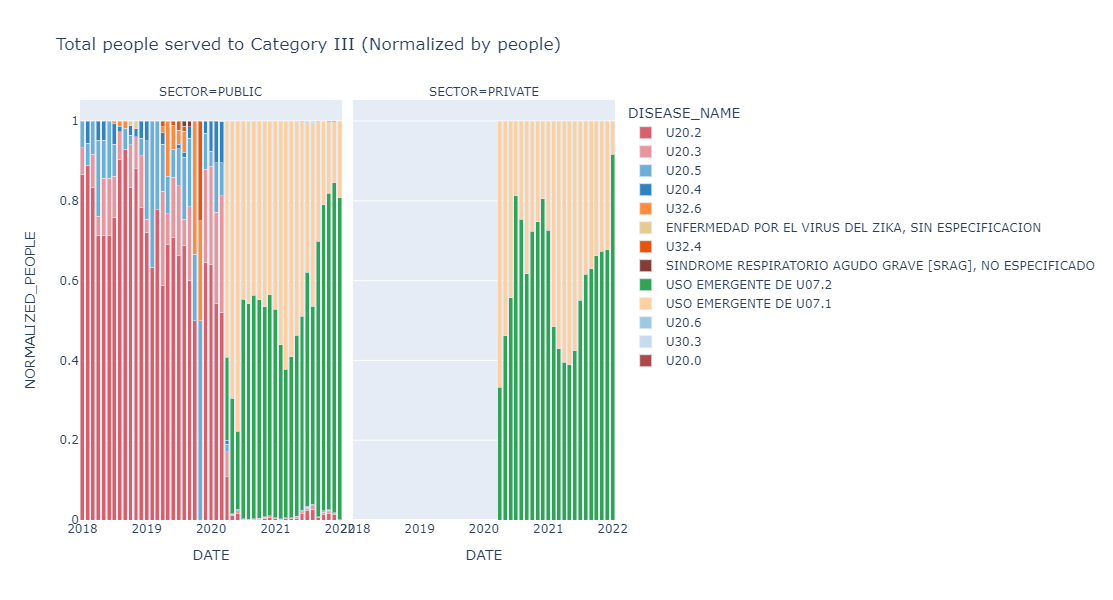

In [429]:
fig = px.bar(data_temp, 
             x="DATE", 
             y="NORMALIZED_PEOPLE", 
             color="DISEASE_NAME", 
             barmode="stack", 
             facet_col="SECTOR",
             width=1500, height=600,
             color_discrete_map = dict_special_colors,
             title='Total people served to Category ' + CATEGORIA_STUDIO + ' (Normalized by people)',
            )


fig.show()
#ig.write_html("figures/special_codes/Sector_Normalized_People_Cat-"+CATEGORIA_STUDIO+"_bar.html")
fig.write_image("figures/special_codes/Sector_Normalized_People_Cat-"+CATEGORIA_STUDIO+"_bar.png", format  = 'png')

# ------------------------------------------------

In [ ]:
###

In [ ]:
# all_data = all_data[(all_data['YEAR']>=2018) & (all_data['YEAR']<2022)]
# np.unique(all_data.DATE)

In [ ]:
all_data.head()

### Forecast

In [ ]:
import plotly.io as pio 
import plotly.graph_objects as go

from pycaret.time_series import *

In [ ]:
!pip3 install pycaret-ts-alpha --user 

In [ ]:
import pycaret

In [ ]:
CATEGORIA_STUDIO = 'I'

In [ ]:
data_temp = all_data[all_data['CATEGORY2']==CATEGORIA_STUDIO]
data_temp =  data_temp.groupby(['DATE', 'SECTOR']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

data_temp['QTY_PEOPLE_SERVED'] =data_temp['QTY_PEOPLE_SERVED'].mask((data_temp['DATE'].dt.year==2018) & (data_temp['DATE'].dt.month==4),data_temp['QTY_PEOPLE_SERVED'].median())

data_temp = data_temp.pivot_table(index=['DATE'], 
                                  columns=['SECTOR'], 
                                  values='QTY_PEOPLE_SERVED').fillna(0)
data_temp = data_temp.reset_index()

In [ ]:
private_max = data_temp['PRIVATE'].mean() + 1*data_temp['PRIVATE'].std()
private_min = data_temp['PRIVATE'].mean() - 1*data_temp['PRIVATE'].std()

data_temp['PRIVATE_PURE'] = data_temp['PRIVATE'].apply(lambda x :
                                                       0 if (private_min>x or
                                                             private_max<x)
                                                       else x)

public_max = data_temp['PUBLIC'].mean() + 1*data_temp['PUBLIC'].std()
public_min = data_temp['PUBLIC'].mean() - 1*data_temp['PUBLIC'].std()

data_temp['PUBLIC_PURE'] = data_temp['PUBLIC'].apply(lambda x :
                                                       0 if (public_min>x or
                                                             public_max<x)
                                                       else x)



In [ ]:
post_pandemic_df = data_temp[(data_temp['DATE'] > '2020-03')]
pre_pandemic_df = data_temp[~(data_temp['DATE'] > '2020-03')]

post_pandemic_df

#### PRIVATE

In [ ]:
index = pre_pandemic_df['DATE'].values
data_to = pre_pandemic_df['PRIVATE'].values
df_series_pre = pd.Series(data = data_to, index = index)
df_series_pre.plot()

In [ ]:
index = post_pandemic_df['DATE'].values
data_to = post_pandemic_df['PRIVATE'].values
df_series = pd.Series(data = data_to, index = index)
df_series.plot()

In [ ]:

setup(data=df_series, fh = 1 , fold = 7)

plot_model(plot = 'diagnostics', 
           fig_kwargs={'renderer': 'png'})

In [ ]:
plot_model(plot = 'decomp_stl', 
           fig_kwargs={'renderer': 'png'})

In [ ]:
best_baseline_models = compare_models( sort='MAE', errors = 'raise', verbose =False) # Media absolute error
best_baseline_models

In [ ]:
#best_baseline_models = 'auto_arima'
the_model = create_model(best_baseline_models)
print(the_model)

tuned_model= tune_model(the_model)
print(tuned_model)

In [ ]:
final_best = finalize_model(the_model)
predict_model(final_best, fh = 1)

abc = plot_model(the_model, 
           plot = 'forecast', 
           data_kwargs = {'fh' : 10}, 
           fig_kwargs={'renderer': 'png'})

In [ ]:
np.mean(df_series_pre)

In [ ]:
setup(data=df_series_pre)
best_baseline_models = compare_models(sort='MAE', errors = 'raise', verbose =False) # Media absolute error
print(best_baseline_models)

In [ ]:
the_model = create_model(best_baseline_models)
print(the_model)

tuned_model= tune_model(the_model)
print(tuned_model)

In [ ]:
final_best = finalize_model(the_model)
predict_model(final_best, fh = 5)

plot_model(the_model, 
           plot = 'forecast', 
           data_kwargs = {'fh' : 5}, 
           fig_kwargs={'renderer': 'png'})

#### PUBLIC

In [ ]:
index = post_pandemic_df['DATE'].values
data_to = post_pandemic_df['PUBLIC'].values
df_series = pd.Series(data = data_to, index = index)

index = pre_pandemic_df['DATE'].values
data_to = pre_pandemic_df['PUBLIC'].values
df_series_pre = pd.Series(data = data_to, index = index)

df_series.plot()

In [ ]:
print("Media: "+str(np.mean(df_series_pre)))

In [ ]:
from pycaret.time_series import *
setup(data=df_series)

plot_model(plot = 'diagnostics', 
           fig_kwargs={'renderer': 'png'})

In [ ]:
best_baseline_models = compare_models(sort='MAE', errors = 'raise', verbose =False) # Media absolute error
best_baseline_models

In [ ]:
#best_baseline_models = 'auto_arima'
the_model = create_model(best_baseline_models)
print(the_model)

tuned_model= tune_model(the_model)
print(tuned_model)

In [ ]:
final_best = finalize_model(best_baseline_models)
final_best = finalize_model(the_model)
predict_model(final_best, fh = 5)

plot_model(the_model, 
           plot = 'forecast', 
           data_kwargs = {'fh' : 5}, 
           fig_kwargs={'renderer': 'png'})

In [ ]:
x =  list(data_to) + list(predict_model(final_best, fh = 5)['y_pred'])
x

In [ ]:
post_pandemic_df.head(50)